## libraries needed

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns

mydevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(mydevice)
# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

cuda:0


## Loading and preprocessing data

In [2]:
# Load dataset from CSV
def load_fashion_mnist(csv_path):
    data = pd.read_csv(csv_path).values
    labels = data[:, 0]
    images = data[:, 1:]

    # Normalize pixel values to [0,1]
    images = images.astype(np.float32) / 255.0

    return images, labels

# Load train and test datasets
train_images, train_labels = load_fashion_mnist("datasets/fashion-mnist_train.csv")
test_images, test_labels = load_fashion_mnist("datasets/fashion-mnist_test.csv")

# Split train into (train + validation)
num_train = int(0.8 * train_images.shape[0])
val_images, val_labels = train_images[num_train:], train_labels[num_train:]
train_images, train_labels = train_images[:num_train], train_labels[:num_train]

print(f"Train: {train_images.shape}, Validation: {val_images.shape}, Test: {test_images.shape}")

Train: (48000, 784), Validation: (12000, 784), Test: (10000, 784)


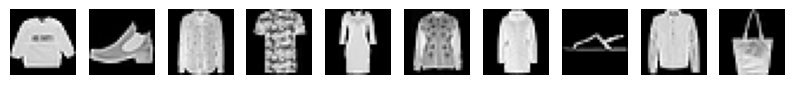

[2 9 6 0 3 4 4 5 4 8]


In [3]:
# printing the first 10 images
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].imshow(train_images[i].reshape(28, 28), cmap="gray")
    ax[i].axis("off")
plt.show()

# printing the first 10 labels
print(train_labels[:10])

### basic pre processing

In [4]:
# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images)
train_labels_tensor = torch.tensor(train_labels)
val_images_tensor = torch.tensor(val_images)
val_labels_tensor = torch.tensor(val_labels)

# dividing the dataset into batches
batch_size = 64
train_data = torch.utils.data.TensorDataset(train_images_tensor,train_labels_tensor )
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)

val_data = torch.utils.data.TensorDataset(val_images_tensor,val_labels_tensor )
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

test_data = torch.utils.data.TensorDataset(torch.tensor(test_images), torch.tensor(test_labels))
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

## Defining Model and Helper functions

### defining basic CNN model with 5 CNN layers

In [5]:
class CNNModel(nn.Module):
    def __init__(self, activation='relu', dropout_rate=0.0, use_batchnorm=False,
                 pooling='max', kernel_sizes=(3, 3, 3, 3, 3),
                 num_filters=(32, 64, 128, 256, 512), init_method='he'):
        super(CNNModel, self).__init__()

        assert len(kernel_sizes) == 5, "kernel_sizes must have 5 elements"
        assert len(num_filters) == 5, "num_filters must have 5 elements"

        self.use_batchnorm = use_batchnorm
        self.init_method = init_method

        # Activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.01)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

        # Pooling
        if pooling == 'max':
            self.pooling = nn.MaxPool2d(kernel_size=2)
        elif pooling == 'avg':
            self.pooling = nn.AvgPool2d(kernel_size=2)
        elif pooling == 'global_avg':
            self.pooling = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        elif pooling == 'none':
            self.pooling = nn.Identity()
        else:
            raise ValueError(f"Unsupported pooling: {pooling}")

        # Batch Normalization
        self.batchnorms = nn.ModuleList()
        if use_batchnorm:
            for num in num_filters:
                self.batchnorms.append(nn.BatchNorm2d(num))

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

        # Convolutional Layers
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(nn.Conv2d(1, num_filters[0], kernel_sizes[0], padding="same"))
        for i in range(1, 5):
            self.conv_layers.append(nn.Conv2d(num_filters[i-1], num_filters[i],
                                            kernel_sizes[i], padding="same"))

        # Dynamically calculate input features for the first linear layer
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, 28, 28)
            x = dummy_input
            for i in range(5):
                x = self.conv_layers[i](x)
                # if use_batchnorm:
                #     x = self.batchnorms[i](x)
                x = self.activation(x)
                if i < 4:
                    x = self.pooling(x)
            flattened_size = x.flatten().shape[0]

        # Fully Connected Layers
        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, 10)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                if self.init_method == 'xavier':
                    nn.init.xavier_normal_(m.weight)
                elif self.init_method == 'he':
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                elif self.init_method == 'random':
                    nn.init.normal_(m.weight, mean=0, std=0.01)

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        shapes = []
        for i in range(5):
            x = self.conv_layers[i](x)
            if self.use_batchnorm and x.size(-1) > 1 and x.size(-2) > 1:
                x = self.batchnorms[i](x)
            x = self.activation(x)
            if i < 4:
                # For global_avg pooling, only apply at the end
                if self.pooling.__class__.__name__ != 'AdaptiveAvgPool2d':
                    x = self.pooling(x)
                    shapes.append(x.shape)

        # Apply global average pooling at the end if selected
        if self.pooling.__class__.__name__ == 'AdaptiveAvgPool2d':
            x = self.pooling(x)

        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)

        return x, shapes

### training code

In [6]:
def train_and_evaluate(model, train_loader, val_loader, epochs=10, device='cuda'):
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)


    # Training
    for epoch in range(epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.view(-1, 1, 28, 28).to(mydevice)
            labels = labels.to(mydevice)

            # Forward pass
            outputs, shapearray = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        total_val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.reshape(-1, 1, 28, 28).to(device)
                labels = labels.to(device)
                outputs, _ = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = total_val_loss / total
        val_accuracy = 100 * correct / total
        scheduler.step(val_loss)  # Update learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, LR: {current_lr}')

    return loss.item(), val_accuracy

## Trying Various Hyperparameter combinations

### configuring hyperparametrs 

In [7]:
def run_experiments():
    # Experiment configurations
    init_methods = ['he', 'xavier', 'random']

    kernel_configs = [
        (3,3,3,3,3),
        (5,5,5,5,5),
        (3,5,3,5,3)
    ]

    filter_configs = [
        (32,32,32,32,32),    # Same filters
        (32,64,128,256,512), # Doubling
        (512,256,128,64,32),    # Halving
        (64,128,256,512,512) # Custom
    ]

    activation_functions = ['relu', 'leaky_relu', 'tanh', 'sigmoid']
    pooling_types = ['max', 'avg', 'global_avg', 'none']
    batch_norm_options = [True, False]
    dropout_rates = [0.0, 0.2, 0.5]

    results = {}

    # Test initialization methods
    print("Testing initialization methods")
    for init_method in init_methods:
        print(f"Initialization: {init_method}")
        model = CNNModel(init_method=init_method).to(mydevice)
        losses, accuracies = train_and_evaluate(model, train_loader, val_loader)
        results[f'init_{init_method}'] = {'loss': losses, 'acc': accuracies}

    # Test kernel configurations
    print("Testing kernel configurations")
    for kernel_size in kernel_configs:
        print(f"Kernel size: {kernel_size}")
        model = CNNModel(kernel_sizes=kernel_size).to(mydevice)
        losses, accuracies = train_and_evaluate(model, train_loader, val_loader)
        results[f'kernel_{kernel_size}'] = {'loss': losses, 'acc': accuracies}

    # Test filter configurations
    print("Testing filter configurations")
    for i, filters in enumerate(filter_configs):
        print(f"Filter config: {filters}")
        model = CNNModel(num_filters=filters).to(mydevice)
        losses, accuracies = train_and_evaluate(model, train_loader, val_loader)
        results[f'filters_{i}'] = {'loss': losses, 'acc': accuracies}

    # Test activation functions
    print("Testing activation functions")
    for activation in activation_functions:
        print(f"Activation: {activation}")
        model = CNNModel(activation=activation).to(mydevice)
        losses, accuracies = train_and_evaluate(model, train_loader, val_loader)
        results[f'activation_{activation}'] = {'loss': losses, 'acc': accuracies}

    # Test pooling types
    print("Testing pooling types")
    for pooling in pooling_types:
        print(f"Pooling: {pooling}")
        model = CNNModel(pooling=pooling).to(mydevice)
        losses, accuracies = train_and_evaluate(model, train_loader, val_loader)
        results[f'pooling_{pooling}'] = {'loss': losses, 'acc': accuracies}

    # Test batch normalization
    print("Testing batch normalization")
    for use_batchnorm in batch_norm_options:
        print(f"BatchNorm: {use_batchnorm}")
        model = CNNModel(use_batchnorm=use_batchnorm).to(mydevice)
        losses, accuracies = train_and_evaluate(model, train_loader, val_loader)
        results[f'batchnorm_{use_batchnorm}'] = {'loss': losses, 'acc': accuracies}

    # Test dropout rates
    print("Testing dropout rates")
    for dropout_rate in dropout_rates:
        print(f"Dropout: {dropout_rate}")
        model = CNNModel(dropout_rate=dropout_rate).to(mydevice)
        losses, accuracies = train_and_evaluate(model, train_loader, val_loader)
        results[f'dropout_{dropout_rate}'] = {'loss': losses, 'acc': accuracies}

    return results

In [8]:
# Run experiments
results = run_experiments()

Testing initialization methods
Initialization: he


/home/pankaj/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10], Training Loss: 0.2214, Val Loss: 0.3240, Val Acc: 88.82%, LR: 0.001
Epoch [2/10], Training Loss: 0.2323, Val Loss: 0.2982, Val Acc: 89.21%, LR: 0.001
Epoch [3/10], Training Loss: 0.2284, Val Loss: 0.2803, Val Acc: 89.82%, LR: 0.001
Epoch [4/10], Training Loss: 0.2110, Val Loss: 0.2869, Val Acc: 89.59%, LR: 0.001
Epoch [5/10], Training Loss: 0.2478, Val Loss: 0.2895, Val Acc: 89.70%, LR: 0.001
Epoch [6/10], Training Loss: 0.2322, Val Loss: 0.2996, Val Acc: 89.97%, LR: 0.0001
Epoch [7/10], Training Loss: 0.2768, Val Loss: 0.2446, Val Acc: 92.26%, LR: 0.0001
Epoch [8/10], Training Loss: 0.2833, Val Loss: 0.2549, Val Acc: 92.32%, LR: 0.0001
Epoch [9/10], Training Loss: 0.3078, Val Loss: 0.2701, Val Acc: 92.42%, LR: 0.0001
Epoch [10/10], Training Loss: 0.3302, Val Loss: 0.2877, Val Acc: 92.45%, LR: 1e-05
Initialization: xavier
Epoch [1/10], Training Loss: 0.2530, Val Loss: 0.3639, Val Acc: 87.08%, LR: 0.001
Epoch [2/10], Training Loss: 0.2402, Val Loss: 0.3016, Val Acc: 88.98%

### plot the results

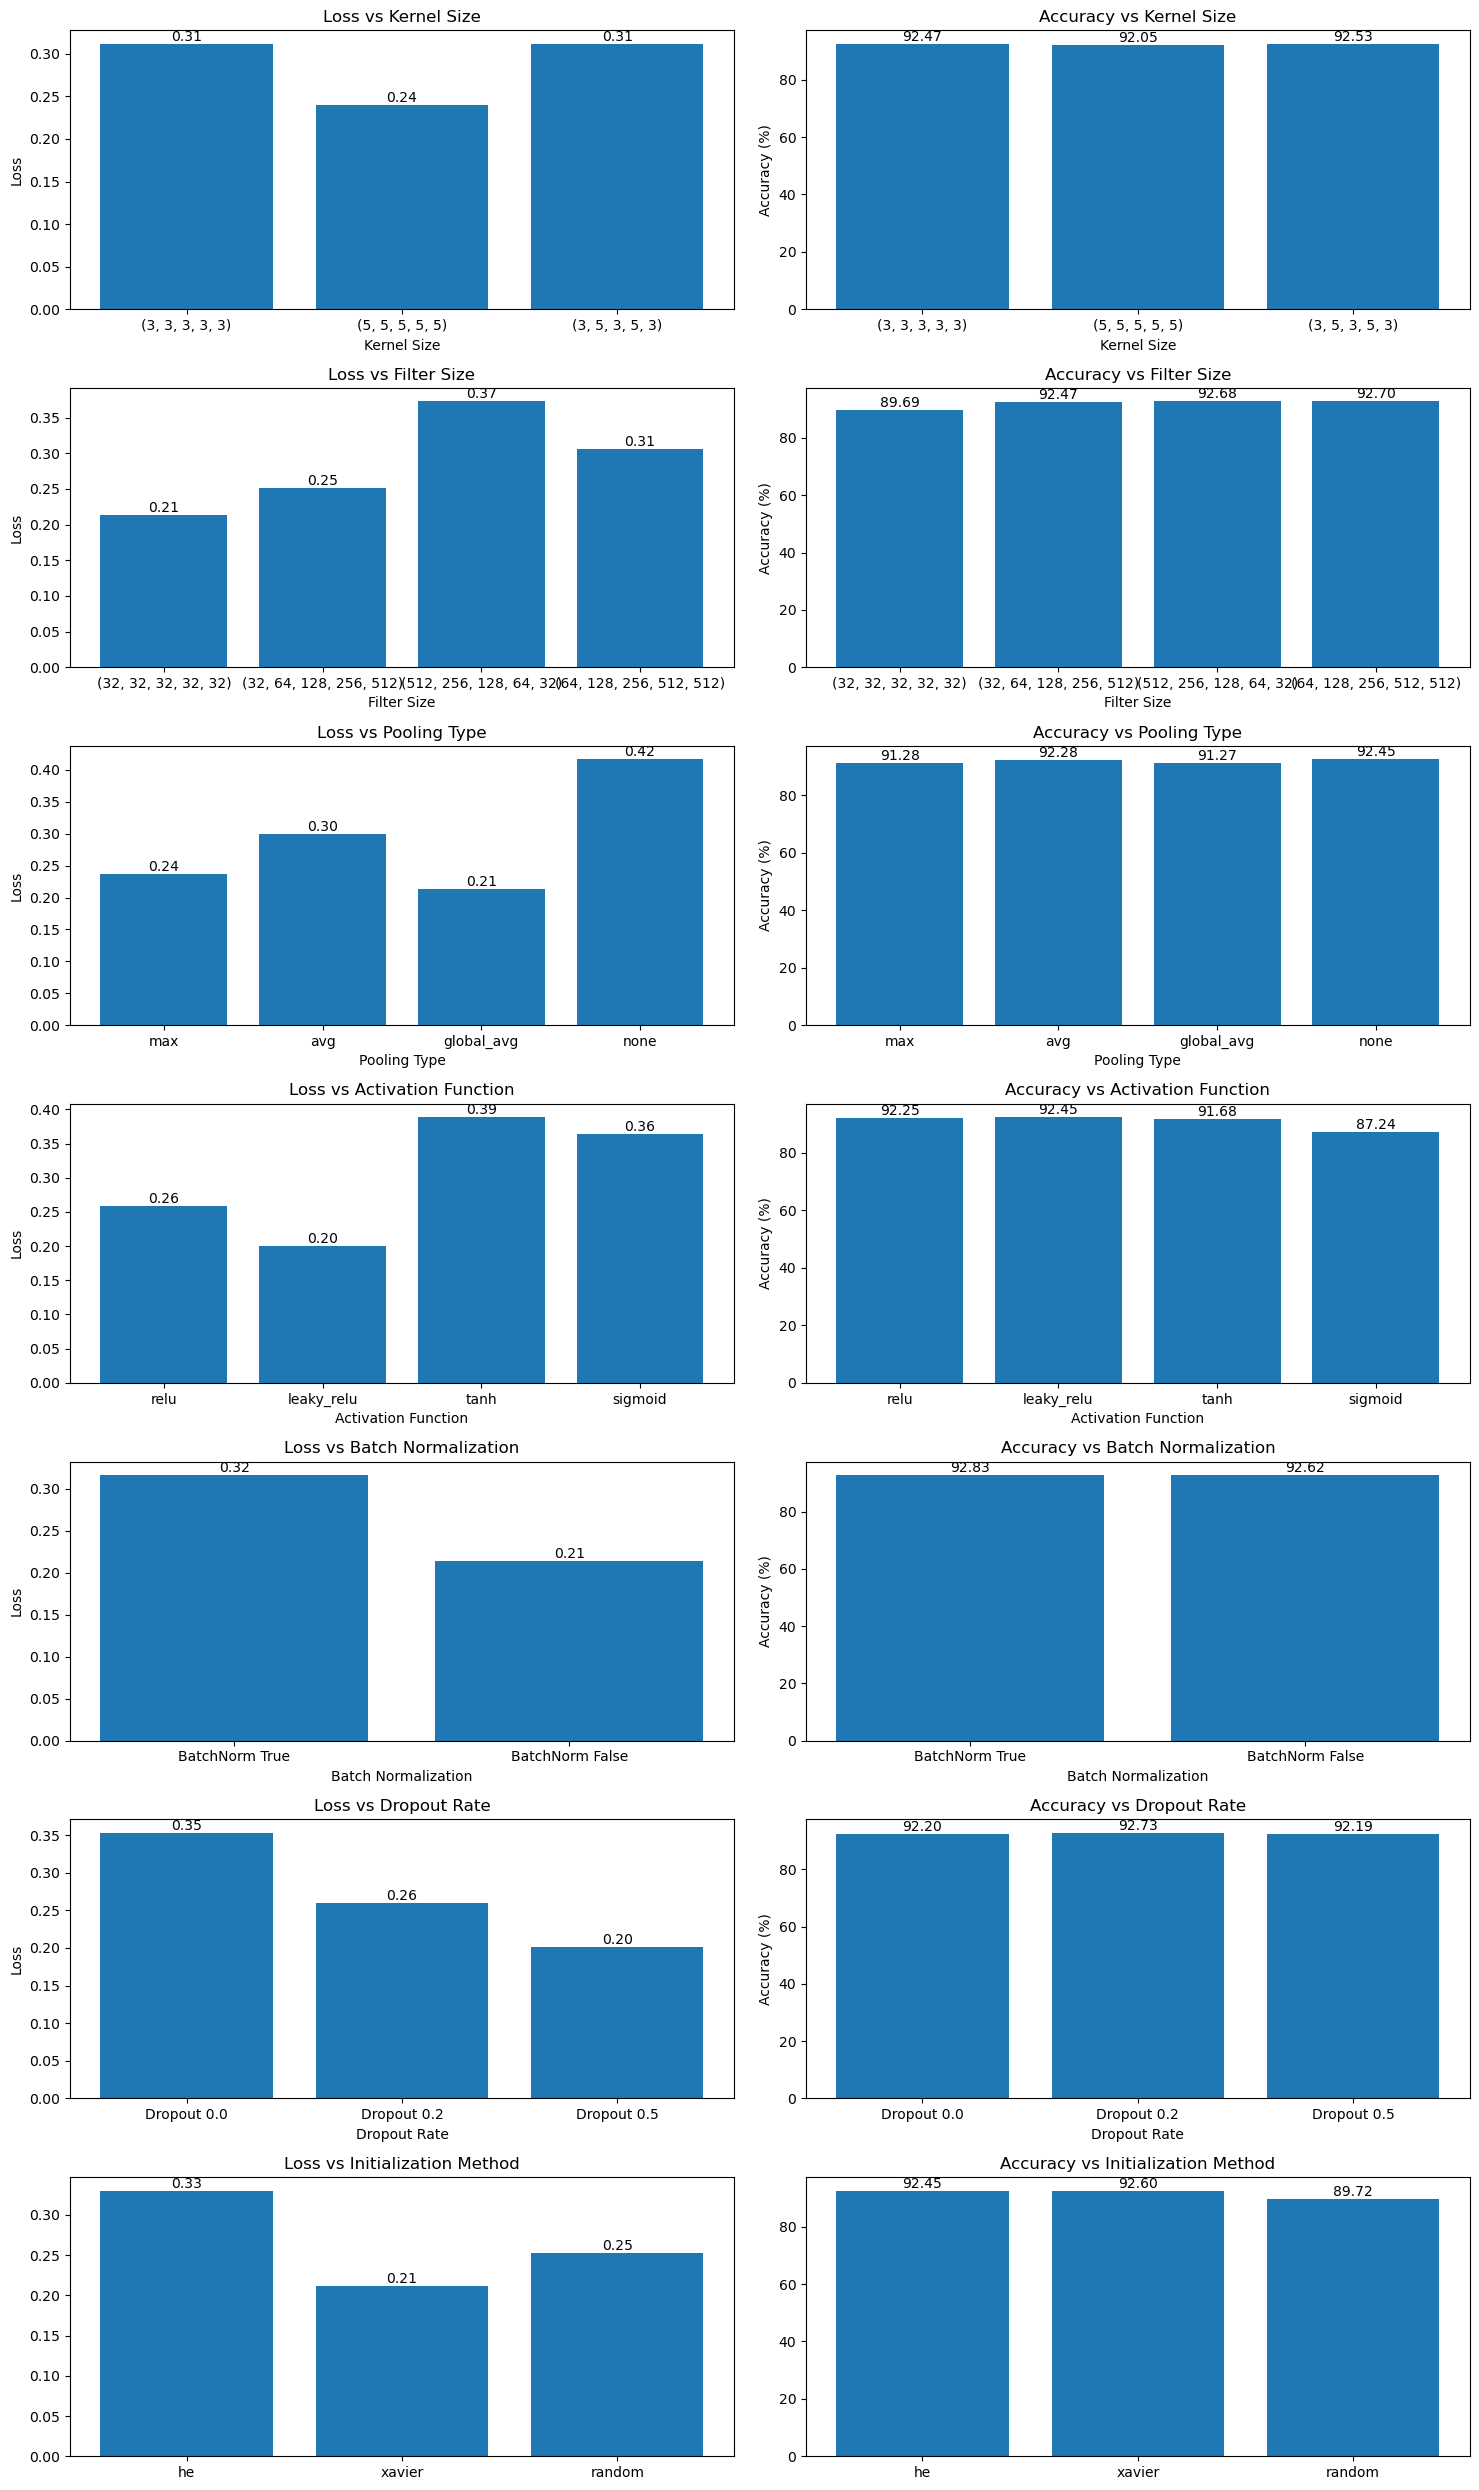

In [9]:
def plot_results(results):

    # Experiment configurations
    init_methods = ['he', 'xavier', 'random']

    kernel_configs = [
        (3,3,3,3,3),
        (5,5,5,5,5),
        (3,5,3,5,3)
    ]

    filter_configs = [
        (32,32,32,32,32),    # Same filters
        (32,64,128,256,512), # Doubling
        (512,256,128,64,32),    # Halving
        (64,128,256,512,512) # Custom
    ]

    activation_functions = ['relu', 'leaky_relu', 'tanh', 'sigmoid']
    pooling_types = ['max', 'avg', 'global_avg', 'none']
    batch_norm_options = [True, False]
    dropout_rates = [0.0, 0.2, 0.5]

    fig, axes = plt.subplots(7, 2, figsize=(15, 25))

    def add_value_labels(ax, rects):
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom')

    # Plot kernel size results
    rects1 = axes[0,0].bar([str(k) for k in kernel_configs],
                          [results[f'kernel_{k}']['loss'] for k in kernel_configs])
    add_value_labels(axes[0,0], rects1)
    axes[0,0].set_title('Loss vs Kernel Size')
    axes[0,0].set_xlabel('Kernel Size')
    axes[0,0].set_ylabel('Loss')

    rects2 = axes[0,1].bar([str(k) for k in kernel_configs],
                          [results[f'kernel_{k}']['acc'] for k in kernel_configs])
    add_value_labels(axes[0,1], rects2)
    axes[0,1].set_title('Accuracy vs Kernel Size')
    axes[0,1].set_xlabel('Kernel Size')
    axes[0,1].set_ylabel('Accuracy (%)')

    # Plot filter size results
    rects3 = axes[1,0].bar([str(k) for k in filter_configs],
                          [results[f'filters_{k}']['loss'] for k in range(len(filter_configs))])
    add_value_labels(axes[1,0], rects3)
    axes[1,0].set_title('Loss vs Filter Size')
    axes[1,0].set_xlabel('Filter Size')
    axes[1,0].set_ylabel('Loss')

    rects4 = axes[1,1].bar([str(k) for k in filter_configs],
                          [results[f'filters_{k}']['acc'] for k in range(len(filter_configs))])
    add_value_labels(axes[1,1], rects4)
    axes[1,1].set_title('Accuracy vs Filter Size')
    axes[1,1].set_xlabel('Filter Size')
    axes[1,1].set_ylabel('Accuracy (%)')

    # Plot pooling results
    rects5 = axes[2,0].bar(pooling_types,
                          [results[f'pooling_{p}']['loss'] for p in pooling_types])
    add_value_labels(axes[2,0], rects5)
    axes[2,0].set_title('Loss vs Pooling Type')
    axes[2,0].set_xlabel('Pooling Type')
    axes[2,0].set_ylabel('Loss')

    rects6 = axes[2,1].bar(pooling_types,
                          [results[f'pooling_{p}']['acc'] for p in pooling_types])
    add_value_labels(axes[2,1], rects6)
    axes[2,1].set_title('Accuracy vs Pooling Type')
    axes[2,1].set_xlabel('Pooling Type')
    axes[2,1].set_ylabel('Accuracy (%)')

    # Plot activation results
    rects7 = axes[3,0].bar(activation_functions,
                          [results[f'activation_{a}']['loss'] for a in activation_functions])
    add_value_labels(axes[3,0], rects7)
    axes[3,0].set_title('Loss vs Activation Function')
    axes[3,0].set_xlabel('Activation Function')
    axes[3,0].set_ylabel('Loss')

    rects8 = axes[3,1].bar(activation_functions,
                          [results[f'activation_{a}']['acc'] for a in activation_functions])
    add_value_labels(axes[3,1], rects8)
    axes[3,1].set_title('Accuracy vs Activation Function')
    axes[3,1].set_xlabel('Activation Function')
    axes[3,1].set_ylabel('Accuracy (%)')

    # Plot batch norm results
    rects9 = axes[4,0].bar(['BatchNorm True', 'BatchNorm False'],
                          [results[f'batchnorm_{bn}']['loss'] for bn in batch_norm_options])
    add_value_labels(axes[4,0], rects9)
    axes[4,0].set_title('Loss vs Batch Normalization')
    axes[4,0].set_xlabel('Batch Normalization')
    axes[4,0].set_ylabel('Loss')

    rects10 = axes[4,1].bar(['BatchNorm True', 'BatchNorm False'],
                          [results[f'batchnorm_{bn}']['acc'] for bn in batch_norm_options])
    add_value_labels(axes[4,1], rects10)
    axes[4,1].set_title('Accuracy vs Batch Normalization')
    axes[4,1].set_xlabel('Batch Normalization')
    axes[4,1].set_ylabel('Accuracy (%)')

    # Plot dropout results
    rects11 = axes[5,0].bar([f'Dropout {rate}' for rate in dropout_rates],
                          [results[f'dropout_{rate}']['loss'] for rate in dropout_rates])
    add_value_labels(axes[5,0], rects11)
    axes[5,0].set_title('Loss vs Dropout Rate')
    axes[5,0].set_xlabel('Dropout Rate')
    axes[5,0].set_ylabel('Loss')

    rects12 = axes[5,1].bar([f'Dropout {rate}' for rate in dropout_rates],
                           [results[f'dropout_{rate}']['acc'] for rate in dropout_rates])
    add_value_labels(axes[5,1], rects12)
    axes[5,1].set_title('Accuracy vs Dropout Rate')
    axes[5,1].set_xlabel('Dropout Rate')
    axes[5,1].set_ylabel('Accuracy (%)')

    # Plot initialization results
    init_methods = ['he', 'xavier', 'random']
    rects13 = axes[6,0].bar(init_methods,
                          [results[f'init_{m}']['loss'] for m in init_methods])
    add_value_labels(axes[6,0], rects13)
    axes[6,0].set_title('Loss vs Initialization Method')

    rects14 = axes[6,1].bar(init_methods,
                          [results[f'init_{m}']['acc'] for m in init_methods])
    add_value_labels(axes[6,1], rects14)
    axes[6,1].set_title('Accuracy vs Initialization Method')

    plt.tight_layout()
    plt.show()

plot_results(results)

## best CNN model Training and Feature extraction

In [10]:
# Best configuration based on experiments
best_model = CNNModel(
    kernel_sizes=(3,3,3,3,3),
    num_filters=(64,128,256,512,512),
    activation='leaky_relu',
    use_batchnorm=True,
    dropout_rate=0.2,
    init_method='he',
    pooling='max'
).to(mydevice)

# Train the best model
train_and_evaluate(best_model, train_loader, val_loader, epochs=15)

Epoch [1/15], Training Loss: 0.3595, Val Loss: 0.3610, Val Acc: 87.30%, LR: 0.001
Epoch [2/15], Training Loss: 0.2628, Val Loss: 0.2816, Val Acc: 89.72%, LR: 0.001
Epoch [3/15], Training Loss: 0.2219, Val Loss: 0.3002, Val Acc: 89.48%, LR: 0.001
Epoch [4/15], Training Loss: 0.2391, Val Loss: 0.2843, Val Acc: 90.13%, LR: 0.001
Epoch [5/15], Training Loss: 0.2149, Val Loss: 0.3227, Val Acc: 89.22%, LR: 0.0001
Epoch [6/15], Training Loss: 0.1972, Val Loss: 0.2187, Val Acc: 93.01%, LR: 0.0001
Epoch [7/15], Training Loss: 0.2119, Val Loss: 0.2306, Val Acc: 93.08%, LR: 0.0001
Epoch [8/15], Training Loss: 0.2270, Val Loss: 0.2521, Val Acc: 93.02%, LR: 0.0001
Epoch [9/15], Training Loss: 0.2578, Val Loss: 0.2871, Val Acc: 92.99%, LR: 1e-05
Epoch [10/15], Training Loss: 0.2515, Val Loss: 0.2823, Val Acc: 93.23%, LR: 1e-05
Epoch [11/15], Training Loss: 0.2570, Val Loss: 0.2892, Val Acc: 93.22%, LR: 1e-05
Epoch [12/15], Training Loss: 0.2636, Val Loss: 0.2969, Val Acc: 93.20%, LR: 1.0000000000000

(0.26754266023635864, 93.24166666666666)

### CNN feature extraction model

In [11]:
class CNNModelFeatures(nn.Module):
    def __init__(self, original_model):
        super(CNNModelFeatures, self).__init__()
        self.original_model = original_model  # Reference layers from the original model

    def forward(self, x):
        # Explicitly replicate the forward steps up to the last conv layer

        # Convolutional Block 1
        x = self.original_model.conv_layers[0](x)
        if self.original_model.use_batchnorm:
            x = self.original_model.batchnorms[0](x)
        x = self.original_model.activation(x)
        x = self.original_model.pooling(x)

        # Convolutional Block 2
        x = self.original_model.conv_layers[1](x)
        if self.original_model.use_batchnorm:
            x = self.original_model.batchnorms[1](x)
        x = self.original_model.activation(x)
        x = self.original_model.pooling(x)

        # Convolutional Block 3
        x = self.original_model.conv_layers[2](x)
        if self.original_model.use_batchnorm:
            x = self.original_model.batchnorms[2](x)
        x = self.original_model.activation(x)
        x = self.original_model.pooling(x)

        # Convolutional Block 4
        x = self.original_model.conv_layers[3](x)
        if self.original_model.use_batchnorm:
            x = self.original_model.batchnorms[3](x)
        x = self.original_model.activation(x)
        # x = self.original_model.pooling(x)

        # Convolutional Block 5 (without pooling)
        x = self.original_model.conv_layers[4](x)
        if self.original_model.use_batchnorm:
            x = self.original_model.batchnorms[4](x)
        x = self.original_model.activation(x)

        # Normalize the features
        x = x / torch.norm(x, p=2, dim=1, keepdim=True)

        return x  # Output shape: [batch, channels, H, W]

### Extracting feature maps from input images

torch.Size([1, 512, 3, 3])


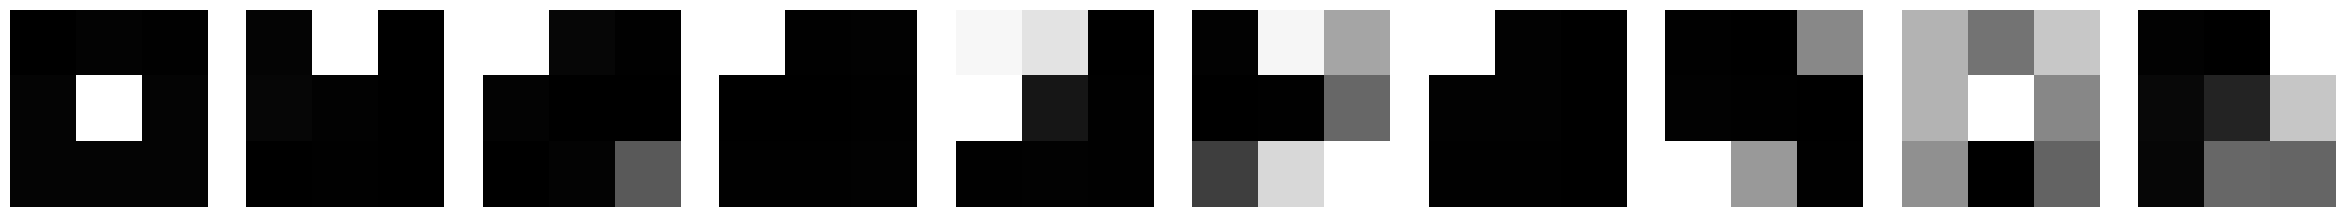

In [12]:
# Extract features using the corrected model
features_model = CNNModelFeatures(best_model)

# Get feature maps for a sample image
sample_image = train_images_tensor[0].view(1, 1, 28, 28).to(mydevice)
feature_maps = features_model(sample_image)  # Shape: [1, 512, H, W]
print(feature_maps.shape)

# Plot feature maps (first 5 channels)
fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(10):
    ax[i].imshow(feature_maps[0, i].detach().cpu().numpy(), cmap='gray')
    ax[i].axis('off')
plt.show()

In [13]:
def extract_features(model, data_loader, device):
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 1, 28, 28).to(device)
            features = model(images)
            flattened_features = features.view(features.size(0), -1)

            all_features.append(flattened_features.cpu())
            all_labels.append(labels)

    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return all_features, all_labels



In [14]:
# Extract features for train and validation sets
train_features, train_feature_labels = extract_features(features_model, train_loader, mydevice)
val_features, val_feature_labels = extract_features(features_model, val_loader, mydevice)

print("Train features shape:", train_features.shape)
print("Validation features shape:", val_features.shape)

Train features shape: torch.Size([48000, 4608])
Validation features shape: torch.Size([12000, 4608])


## Manual MLP model training with Extracted features from CNN Backbone model.

In [15]:
# Activation functions
def gelu(Z):
    return 0.5 * Z * (1 + np.tanh(np.sqrt(2 / np.pi) * (Z + 0.044715 * Z ** 3)))

def gelu_derivative(Z):
    return 0.5 * (1 + np.tanh(np.sqrt(2 / np.pi) * (Z + 0.044715 * Z ** 3))) + (Z * (1 - np.tanh(np.sqrt(2 / np.pi) * (Z + 0.044715 * Z ** 3)) ** 2) * (np.sqrt(2 / np.pi) * (1 + 3 * 0.044715 * Z ** 2)) * 0.5)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / np.sum(expZ, axis=1, keepdims=True)

def cross_entropy_loss(Y_true, Y_pred):
    return -np.mean(np.sum(Y_true * np.log(Y_pred + 1e-9), axis=1))

### Forward and Backward pass functions

In [16]:
def forward_pass(X, network_weights, dropout_rate=0.2, activation_function=gelu):
    """
    network_weights: list of tuples (W, b) for each set of weights.
    layer_outputs: list of tuples (Z, A, mask) for each layer.
    For the output layer, mask is None.
    """
    layer_outputs = []
    A = X
    for i, (W, b) in enumerate(network_weights):
        Z = np.matmul(A, W) + b
        if i == len(network_weights) - 1:
            A = softmax(Z)
            mask = None
        else:
            A = activation_function(Z)
            mask = (np.random.rand(*A.shape) > dropout_rate)
            A = A * mask / (1 - dropout_rate)
        layer_outputs.append((Z, A, mask))
    return layer_outputs

In [17]:
def backward_pass(X, Y, network_weights, layer_outputs, dropout_rate=0.2, learning_rate=0.05, activation_derivative=gelu_derivative):
    """
    X, Y
    network_weights: List of (W, b) tuples.
    layer_outputs: List of (Z, A, mask) tuples afer the forward pass.
    Returns updated list of network_weights.
    """
    m = X.shape[0]
    L = len(network_weights)
    grads = [None] * L

    ZL, AL, _ = layer_outputs[-1] # '_' to ignore mask of output layer
    dZ = AL - Y

    A_prev = layer_outputs[-2][1] if L > 1 else X  # if-else to handle one layer case
    dW = np.matmul(A_prev.T, dZ) / m
    db = np.mean(dZ, axis=0, keepdims=True)
    grads[-1] = (dW, db) # gradient of last layer

    dA_prev = np.matmul(dZ, network_weights[-1][0].T)


    for i in reversed(range(L - 1)):
        Z, A, mask = layer_outputs[i] # same mask of forward pass
        A_prev = X if i == 0 else layer_outputs[i-1][1]

        dA = dA_prev * mask / (1 - dropout_rate)
        dZ = dA * activation_derivative(Z)
        dW = np.matmul(A_prev.T, dZ) / m
        db = np.mean(dZ, axis=0, keepdims=True)
        grads[i] = (dW, db)

        dA_prev = np.matmul(dZ, network_weights[i][0].T) #dA_prev for next layer


    #weights update
    for i in range(L):
        W, b = network_weights[i]
        dW, db = grads[i]
        network_weights[i] = (W - learning_rate * dW, b - learning_rate * db)

    return network_weights

### preprocessing data and hyperparameter initialisation

In [18]:
def one_hot_encode(y, num_classes=10):
    y = y.astype(int)
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

x_train = train_features.numpy()
x_val = val_features.numpy()
y_train = one_hot_encode(train_labels)
y_val = one_hot_encode(val_labels)


learning_rate = 0.05
epochs = 60
batch_size = 32
dropout_rate = 0.2

layer_dims = [4608, 256, 64, 10]
network_weights = []
np.random.seed(25)
for i in range(1, len(layer_dims)):
    W = np.random.randn(layer_dims[i-1], layer_dims[i]) * np.sqrt(2/layer_dims[i-1])
    b = np.zeros((1, layer_dims[i]))
    network_weights.append((W, b))



### Training and predicting

In [19]:
loss_array = []
prev_loss = float('inf')
accuracy_array = []

def predict(X, network_weights):
    layer_outputs = forward_pass(X, network_weights, dropout_rate=0)  # No dropout at test time
    return np.argmax(layer_outputs[-1][1], axis=1)

for epoch in range(epochs):
    indices = np.random.permutation(x_train.shape[0])
    x_train_shuffled = x_train[indices]
    y_train_shuffled = y_train[indices]

    epoch_loss = 0
    for i in range(0, x_train.shape[0], batch_size):
        X_batch = x_train_shuffled[i:i+batch_size]
        Y_batch = y_train_shuffled[i:i+batch_size]

        # Forward pass
        layer_outputs = forward_pass(X_batch, network_weights, dropout_rate)

        Y_pred = layer_outputs[-1][1] # last layer
        loss = cross_entropy_loss(Y_batch, Y_pred)
        epoch_loss += loss

        #Backward pass
        network_weights = backward_pass(X_batch, Y_batch, network_weights, layer_outputs, dropout_rate, learning_rate)

    loss_array.append(epoch_loss)

    if epoch_loss > prev_loss:
        learning_rate /= 2
        print("Learning rate decreased!!!")
        print("Learning rate = ", learning_rate)

    prev_loss = epoch_loss

    if (epoch + 1) % 5 == 0:
        y_pred = predict(x_val, network_weights)
        y_true = np.argmax(y_val, axis=1)
        accuracy = np.mean(y_pred == y_true)
        accuracy_array.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")
    else:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/60, Loss: 860.3413
Epoch 2/60, Loss: 178.3199
Epoch 3/60, Loss: 134.8928
Epoch 4/60, Loss: 114.2997
Epoch 5/60, Loss: 101.0242, Accuracy: 92.77%
Epoch 6/60, Loss: 93.2865
Epoch 7/60, Loss: 87.1482
Epoch 8/60, Loss: 80.4713
Epoch 9/60, Loss: 74.7409
Epoch 10/60, Loss: 70.9365, Accuracy: 92.72%
Epoch 11/60, Loss: 67.5742
Epoch 12/60, Loss: 64.8663
Epoch 13/60, Loss: 63.0370
Epoch 14/60, Loss: 60.6074
Epoch 15/60, Loss: 58.0251, Accuracy: 92.73%
Epoch 16/60, Loss: 55.8266
Epoch 17/60, Loss: 55.2439
Epoch 18/60, Loss: 53.6418
Epoch 19/60, Loss: 50.7527
Epoch 20/60, Loss: 50.0650, Accuracy: 92.74%
Epoch 21/60, Loss: 49.9462
Epoch 22/60, Loss: 49.2524
Epoch 23/60, Loss: 48.3423
Epoch 24/60, Loss: 46.1108
Epoch 25/60, Loss: 44.8305, Accuracy: 92.85%
Learning rate decreased!!!
Learning rate =  0.025
Epoch 26/60, Loss: 44.8684
Epoch 27/60, Loss: 41.2705
Learning rate decreased!!!
Learning rate =  0.0125
Epoch 28/60, Loss: 41.4667
Epoch 29/60, Loss: 39.9890
Epoch 30/60, Loss: 39.3196, Ac

### Plotting results

<Figure size 1000x600 with 0 Axes>

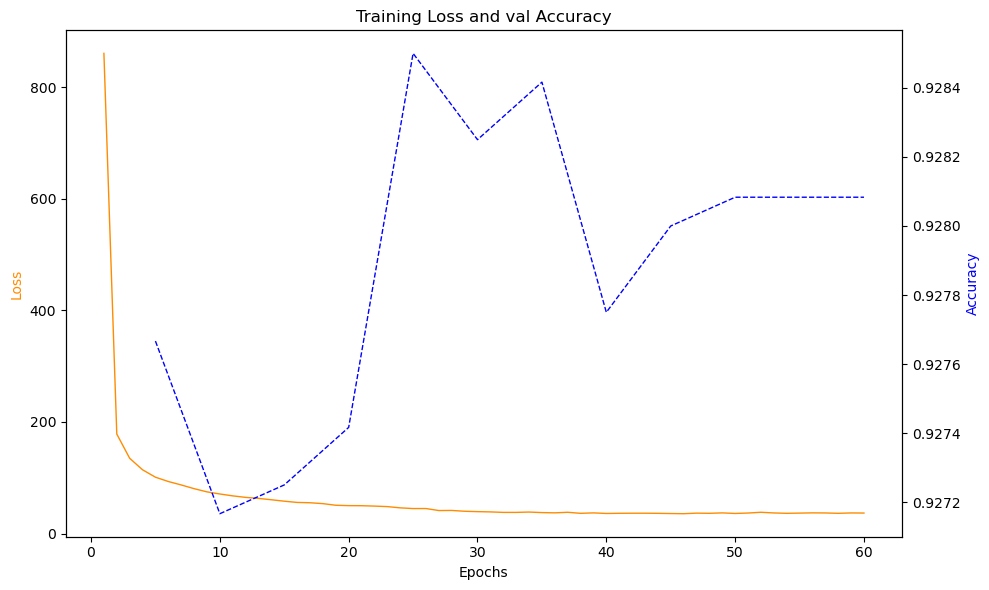

In [20]:
plt.figure(figsize=(10, 6))
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(range(1, epochs + 1), loss_array, color='darkorange', linestyle='-', linewidth=1, label='Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='darkorange')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(range(5, epochs + 1, 5), accuracy_array, color='blue', linestyle='--', linewidth=1, label='Accuracy')
ax2.set_ylabel('Accuracy', color='blue')
ax2.tick_params(axis='y')

plt.title('Training Loss and val Accuracy')
fig.tight_layout()
plt.show()

### Prediction on Test dataset

Test Accuracy: 0.9300


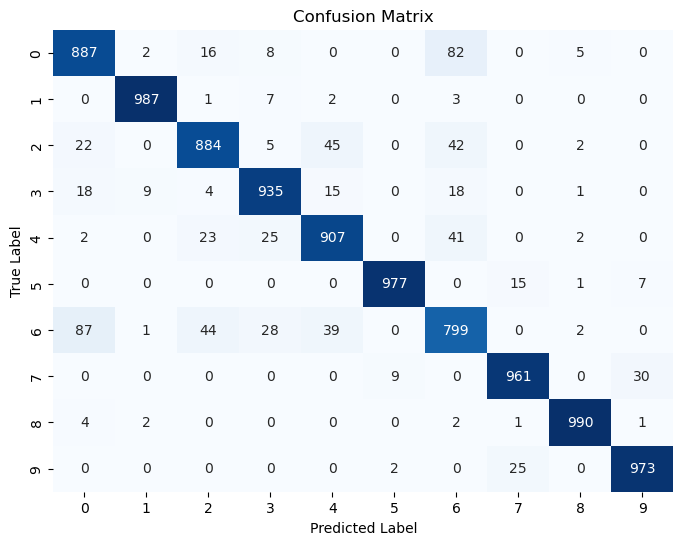

In [21]:
# Evaluate on test set
test_features, test_feature_labels = extract_features(features_model, test_loader, mydevice)

# Convert PyTorch tensors to NumPy arrays
test_features = test_features.numpy()
test_labels = test_feature_labels.numpy()

y_pred = predict(test_features, network_weights)
y_true = test_labels
test_accuracy = np.mean(y_pred == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
